In [1]:
import sys, os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    top_k_accuracy_score,
    classification_report,
    confusion_matrix
)
import random
from pathlib import Path
import torch.nn.functional as F


In [2]:
# Compute absolute path to the `src/` folder
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_PATH     = os.path.join(PROJECT_ROOT, "src")

if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

from utils import get_dataloaders, load_model, evaluate_model, print_metrics, plot_confusion_matrix, show_sample_predictions, plot_random_image_with_label_and_prediction, gradCAM, load_vit_model

/opt/anaconda3/envs/cv_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: mps


In [5]:
COUNTRIES = ['Albania', 'Andorra', 'Australia', 'Austria', 'Bangladesh', 'Belgium', 'Bhutan', 'Bolivia', 'Brazil', 'Bulgaria', 'Cambodia', 'Canada', 'Chile', 'Colombia', 'Croatia', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Estonia', 'Eswatini', 'Finland', 'France', 'Germany', 'Greece', 'Guatemala', 'Hungary', 'Iceland', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Japan', 'Jordan', 'Latvia', 'Lesotho', 'Lithuania', 'Luxembourg', 'Malaysia', 'Mexico', 'Montenegro', 'Netherlands', 'New Zealand', 'North Macedonia', 'Norway', 'Palestine', 'Peru', 'Poland', 'Portugal', 'Romania', 'Russia', 'Serbia', 'Singapore', 'Slovakia', 'Slovenia', 'South Africa', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Turkey', 'United Arab Emirates', 'United Kingdom', 'United States']
num_classes = len(COUNTRIES)
project_root   = Path().resolve().parent

## Model on 80 bad images

### Data

In [ ]:
test_root  = project_root/ "data" / "processed_data" / "small_dataset" / "test"
test_loader = get_dataloaders(test_root, batch_size=32)

### Load model

In [ ]:
model = load_model(model_path=project_root / "models" / "resnet_finetuned" / "small_models" / "resnet_finetuned_bs32.pth", device=device)

/Users/michelangelonardi/Desktop/Università/Master/Bocconi Master/Year 1/Semester2/Computer Vision & Image processing/Final - project/rainbot/src/utils.py:212: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relate

### Evaluation

In [11]:
criterion = nn.CrossEntropyLoss()

In [17]:
avg_loss, top1_acc, all_targets, all_preds, all_probs = evaluate_model(model, test_loader, criterion, device)
print("Average loss:", avg_loss)
print("Top-1 accuracy:", top1_acc)

Average loss: 2.728294968303246
Top-1 accuracy: 0.30253164556962026


In [15]:
print_metrics(all_targets, all_preds, all_probs, COUNTRIES)

Top-3 Accuracy: 0.4975
Top-5 Accuracy: 0.5911

Classification Report:

                      precision    recall  f1-score   support

             Albania       0.25      0.30      0.27        10
             Andorra       0.64      0.70      0.67        10
           Argentina       0.22      0.20      0.21        10
           Australia       0.44      0.40      0.42        10
             Austria       0.50      0.50      0.50        10
          Bangladesh       0.67      0.20      0.31        10
             Belgium       0.00      0.00      0.00        10
              Bhutan       0.50      0.70      0.58        10
             Bolivia       0.10      0.10      0.10        10
            Botswana       0.75      0.90      0.82        10
              Brazil       0.00      0.00      0.00        10
            Bulgaria       0.80      0.40      0.53        10
            Cambodia       0.00      0.00      0.00        10
              Canada       0.12      0.20      0.15        1

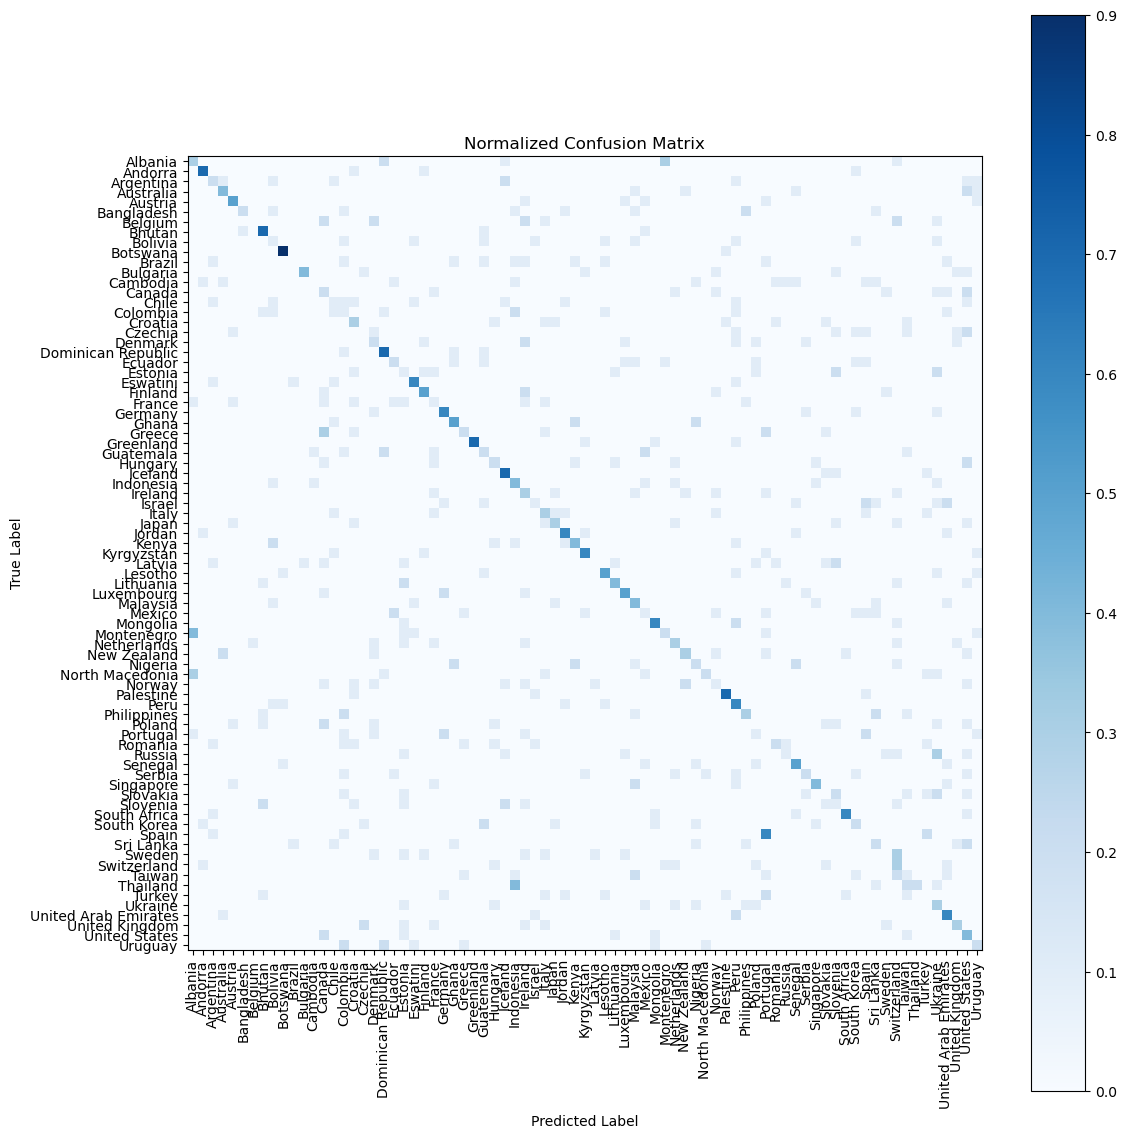

In [18]:
plot_confusion_matrix(all_targets, all_preds, COUNTRIES)

In [20]:
show_sample_predictions(all_targets, all_probs, COUNTRIES, n=5)


Sample predictions (5 examples):

True: Eswatini              ↔  Pred Top-3: Peru (0.40), United Arab Emirates (0.11), Argentina (0.07)
True: Lesotho               ↔  Pred Top-3: Botswana (0.60), Argentina (0.11), Kenya (0.10)
True: Colombia              ↔  Pred Top-3: Lesotho (0.34), Ecuador (0.17), Colombia (0.15)
True: Canada                ↔  Pred Top-3: Ukraine (0.34), United States (0.32), Canada (0.09)
True: South Korea           ↔  Pred Top-3: South Korea (0.28), United Arab Emirates (0.19), Peru (0.08)


## Model on 360 good images

### Data

In [11]:
test_root = project_root/ "data" / "final_datasets" / "test"
test_loader = get_dataloaders(test_root, batch_size=32)

In [12]:
get_dataloaders(test_root, batch_size=32)

### Load model

In [13]:
model = load_model(model_path=project_root / "models" / "resnet_finetuned" / "main.pth", device=device)

/Users/michelangelonardi/Desktop/Università/Master/Bocconi Master/Year 1/Semester2/Computer Vision & Image processing/Final - project/rainbot/src/utils.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relate

### Evaluation

In [14]:
criterion = nn.CrossEntropyLoss()

In [15]:
avg_loss, top1_acc, all_targets, all_preds, all_probs = evaluate_model(model, test_loader, criterion, device)
print("Average loss:", avg_loss)
print("Top-1 accuracy:", top1_acc)

Average loss: 1.5284139307742381
Top-1 accuracy: 0.5952180028129396


In [16]:
print_metrics(all_targets, all_preds, all_probs, COUNTRIES)

Top-3 Accuracy: 0.7783
Top-5 Accuracy: 0.8405

Classification Report:

                      precision    recall  f1-score   support

             Albania       0.76      0.62      0.68        45
             Andorra       0.71      0.93      0.81        45
           Argentina       0.43      0.44      0.44        45
           Australia       0.73      0.67      0.70        45
             Austria       0.66      0.69      0.67        45
          Bangladesh       0.81      0.67      0.73        45
             Belgium       0.36      0.58      0.44        45
              Bhutan       0.81      0.76      0.78        45
             Bolivia       0.61      0.44      0.51        45
            Botswana       0.78      0.84      0.81        45
              Brazil       0.76      0.62      0.68        45
            Bulgaria       0.66      0.47      0.55        45
            Cambodia       0.43      0.64      0.51        45
              Canada       0.64      0.76      0.69        4

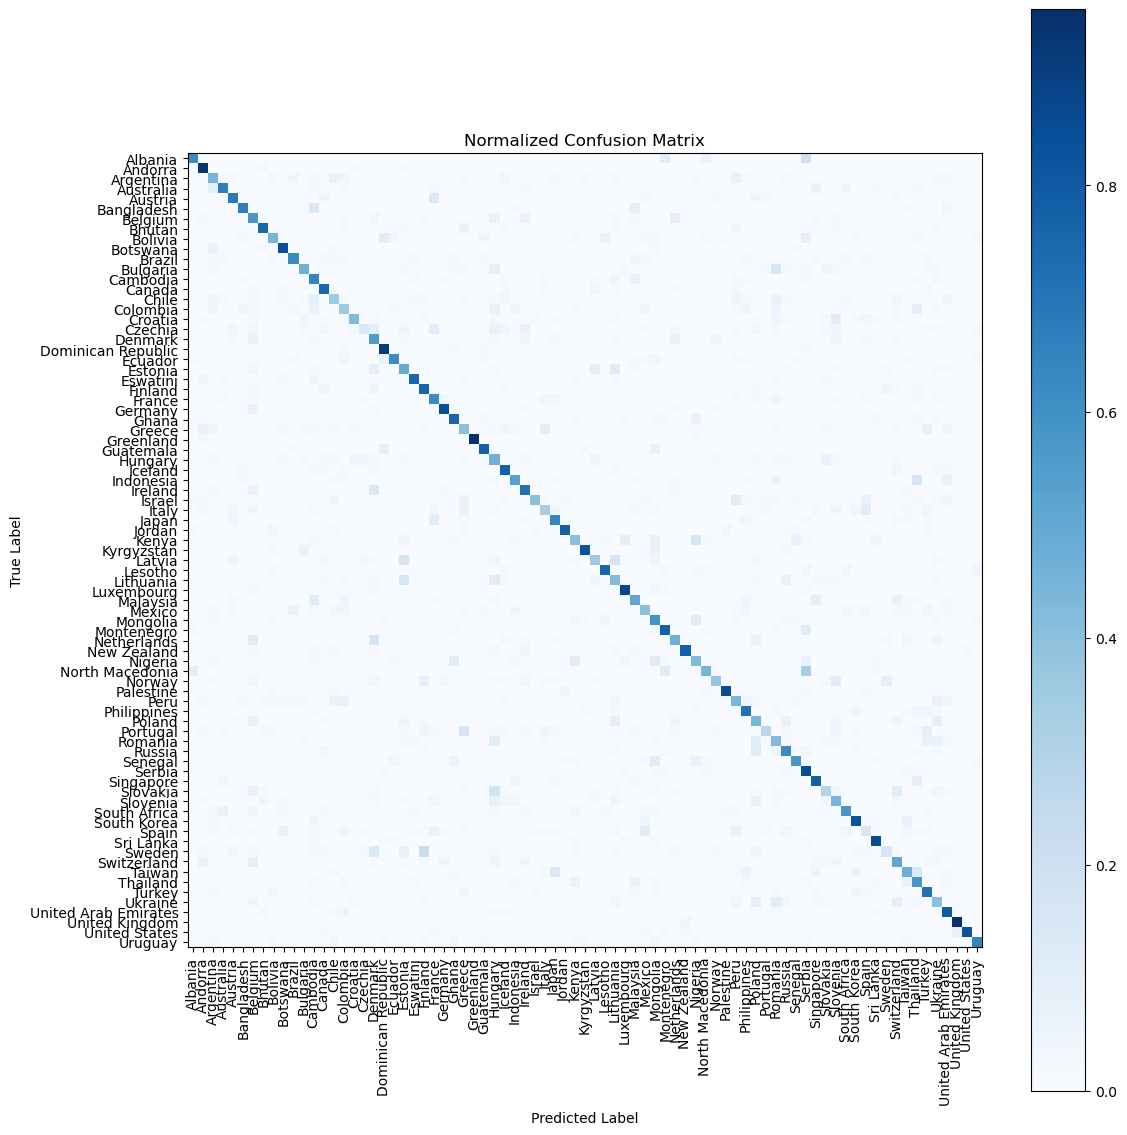

In [17]:
plot_confusion_matrix(all_targets, all_preds, COUNTRIES)

In [24]:
show_sample_predictions(all_targets, all_probs, COUNTRIES, n=5)


Sample predictions (5 examples):

True: Denmark               ↔  Pred Top-3: Belgium (0.37), Denmark (0.13), Czechia (0.09)
True: Bhutan                ↔  Pred Top-3: Bhutan (0.99), Eswatini (0.00), Greece (0.00)
True: Philippines           ↔  Pred Top-3: Philippines (0.95), Thailand (0.02), Cambodia (0.02)
True: Greenland             ↔  Pred Top-3: Greenland (1.00), Iceland (0.00), Montenegro (0.00)
True: Ecuador               ↔  Pred Top-3: Ecuador (1.00), Guatemala (0.00), Mongolia (0.00)


### Test predictions vs human

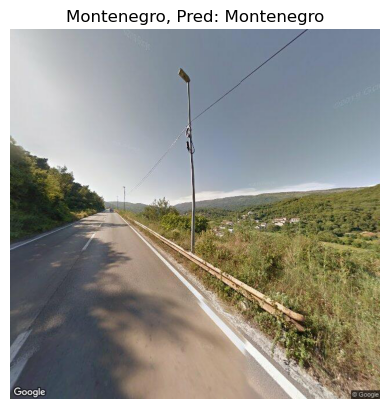

In [31]:
plot_random_image_with_label_and_prediction(test_root, model, device)

### GradCAM

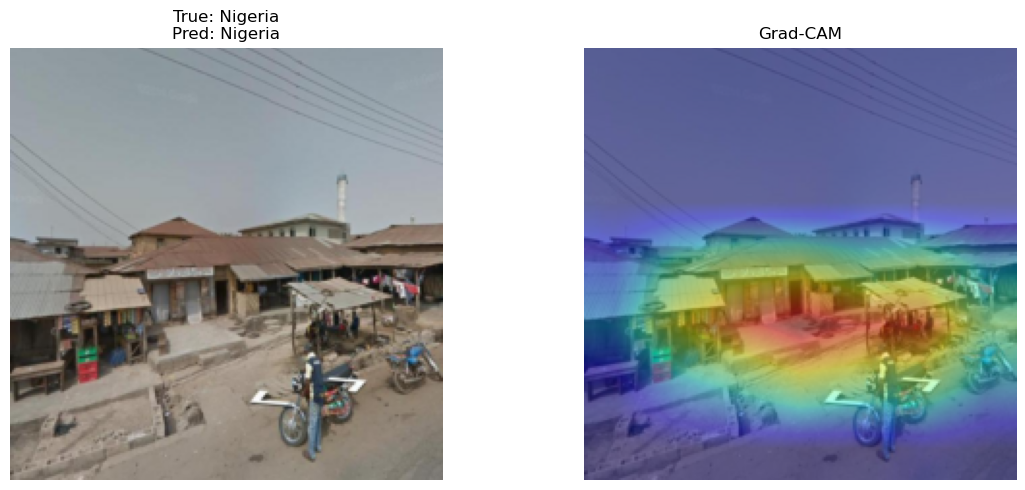

In [58]:
gradCAM(test_root, model, device)

## Eval ViT

In [6]:
test_root = project_root/ "data" / "final_datasets" / "test"
test_loader = get_dataloaders(test_root, batch_size=32)

In [7]:
get_dataloaders(test_root, batch_size=32)

### Load model

In [10]:
base_vit = load_vit_model(model_path=project_root / "models" / "swin_b_finetuned" / "swin_b_finetuned", device=device)
vit_road = load_vit_model(model_path=project_root / "models" / "swin_b_finetuned" / "swin_b_finetuned_road", device=device)
vit_terrain = load_vit_model(model_path=project_root / "models" / "swin_b_finetuned" / "swin_b_finetuned_terrain", device=device)
vit_vegetation = load_vit_model(model_path=project_root / "models" / "swin_b_finetuned" / "swin_b_finetuned_vegetation", device=device)

### Evaluation

In [20]:
criterion = nn.CrossEntropyLoss()
softmax = torch.nn.Softmax(dim=1)

In [22]:
def evaluate_vit_model(model, data_loader, criterion, device):
    """
    Runs model on data_loader and returns:
      - avg_loss: float
      - top1_acc: float
      - all_targets: np.array shape (N,)
      - all_preds:   np.array shape (N,)
      - all_probs:   np.array shape (N, num_classes)
    """
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    all_preds, all_targets, all_probs = [], [], []

    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            logits  = outputs.logits 
            loss    = criterion(logits, labels)

            # accumulate loss & top‐1 accuracy
            batch_size = imgs.size(0)
            total_loss    += loss.item() * batch_size
            preds         = logits.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += batch_size

            # store for detailed metrics
            all_probs.append(softmax(logits).cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_targets.append(labels.cpu().numpy())

    # flatten
    all_probs   = np.vstack(all_probs)
    all_preds   = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    avg_loss = total_loss / total_samples
    top1_acc = total_correct / total_samples

    return avg_loss, top1_acc, all_targets, all_preds, all_probs

In [28]:
def evaluate_vit_model_topk(model, data_loader, criterion, device, topk=(1,3,5)):
    """
    Runs the model on data_loader and returns a dict of top-k accuracies.

    Returns:
      {1: top1_acc, 3: top3_acc, 5: top5_acc}
    """
    model.eval()
    all_targets, all_probs = [], []

    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            logits  = outputs.logits

            all_probs.append(softmax(logits).cpu().numpy())
            all_targets.append(labels.cpu().numpy())

    # Flatten
    all_probs   = np.vstack(all_probs)       # shape (N, C)
    all_targets = np.concatenate(all_targets) # shape (N,)

    # Compute top-k accs
    accs = {}
    for k in topk:
        accs[k] = top_k_accuracy_score(
            all_targets, all_probs, k=k, labels=np.arange(all_probs.shape[1])
        )

    return accs

In [30]:
for model in [vit_terrain, vit_vegetation]:
    accs = evaluate_vit_model_topk(model, test_loader, criterion, device)
    print(f"\nModel: {model.__class__.__name__}")
    print(f"  Top-1 Acc: {accs[1]:.4f}")
    print(f"  Top-3 Acc: {accs[3]:.4f}")
    print(f"  Top-5 Acc: {accs[5]:.4f}")


Model: SwinForImageClassification
  Top-1 Acc: 0.0141
  Top-3 Acc: 0.0434
  Top-5 Acc: 0.0724

Model: SwinForImageClassification
  Top-1 Acc: 0.0148
  Top-3 Acc: 0.0468
  Top-5 Acc: 0.0801
